# Special - bluepy vs bluepysnap

In this notebook we will show the API differences from bluepy to bluepysnap. Bluepy has been around for a very long time and has been the main tool for the circuit exploration and analyses for years. Unfortunately, with the emergence of [SONATA](https://github.com/AllenInstitute/sonata/blob/master/docs/SONATA_DEVELOPER_GUIDE.md) circuits and the apparition of complex circuits like NGV, bluepy needed a almost complete rework/redesign.

The complete bluepy revamp is called Bluepysnap and it is designed to improve the sonata circuit reading, analyses and the user experience in general. 

## Motivations behind the bluepy rework

The main complexity for bluepy today is to keep analyses compatible between the new and the old circuits while maintaining a coherent interface for circuit analysis. 

Two of the most obvious problems right now with bluepy is to merge SONATA multi-populations with the historical formats under a common API and to be able to read all new coming types of cells/connectomes.  
Multi-population was not a thing with the historical circuits. Indeed `BlueConfig`, `target files`, `nrn` and `mvd` formats have been designed to represent a **single neuron** population circuit. Bluepy has been initially designed to deal with this kind of circuits and adding multi-populations to it would be very hacky or will force a full revamp of the historical API which would break the current codes.  
Few years ago, only neurons were used to create circuits and it was not useful to mix different types of cells or adding new connection types. With this huge homogeneity constraint, many simplifications have been made to the historical formats. One of it was to fix the storable in-file properties of the cells or the connectomes. But today, new types of cells are produced at BBP and these cells cannot fit into the "neuron scheme". We need to keep in mind that bluepy has been first designed to deal with this type of constrained circuits and most parts of the current API is dedicated/specialized to/for the neuronal analyses only. For example, bluepy connectome API uses many functions that include the word "synapses" in them but the concept of synapses does not make sense for most of the new connectomes (like a vasculature-astrocyte connectome where an astrocyte actually connect the vasculature via a endfoot). This is also true for the cells API which contains the word `GID` a lot which does not really exist in SONATA. So a new API more data agnostic should be developed to avoid querying enfeet properties using a function called : synapse_properties. 

As you can see, the initial design of bluepy starts to cause many maintenance difficulties and in the worst case scenarios, it will be impossible to analyze certain types of cells with bluepy, it can lead to restrictions in the analyses or forces the use of only a subset of the SONATA functionalities.  
So it was obvious, we needed a more SONATA compliant and "cell agnostic" tool at BBP and that's why we created bluepysnap (shorten in "snap" in this notebook). 

In this notebook, we will describe the differences between snap and the additions made to snap compared to bluepy for the cell, connectome and simulation analyses.  
We will not spend too much time on the SONATA basics. For information about the format please read the [specifications](https://github.com/AllenInstitute/sonata/blob/master/docs/SONATA_DEVELOPER_GUIDE.md) or the [BBP extension document](https://sonata-extension.readthedocs.io/en/latest/sonata_overview.html).

## Loading a circuit

First, let's start with the basics and the circuit loading. We can load a circuit just as bluepy does via a path to a valid config file:

In [1]:
from bluepy import Circuit, Cell
from bluepysnap import Circuit as SnapCircuit  # SnapCircuit is use only to avoid the name conflict with the bluepy Circuit

In [2]:
circuit_path = "/gpfs/bbp.cscs.ch/project/proj12/NSE/bluepy/circuits/CA1.O1/mooc-circuit/CircuitConfig"  # bluepy
bluepy_circuit = Circuit(circuit_path)  # bluepy

circuit_path = "/gpfs/bbp.cscs.ch/project/proj12/NSE/bluepy/circuits/CA1.O1/mooc-circuit/circuit_config.json" # snap
snap_circuit = SnapCircuit(circuit_path) # snap

As you can see snap does not use BlueConfig but a SONATA config files. 

<div class="alert alert-block alert-info">
<b>Note:</b> This circuit is the hippocampus mooc circuit. It consists in a O1 circuit containing the hippocampus CA1 cells and a projection connectome linking CA3 to CA1.
</div>

We will now start to explore the circuit using snap and bluepy APIs.

## Populations and CircuitIds

One very major update from the SONATA format is the introduction of the populations. A population is a sub sample of either the nodes or the edges from a circuit. That is, a subsample of the cells or connectomes.

Two node populations can be neurons from two different sub-regions or totally different objects like neurons and astrocytes. It is important to keep in mind that these populations do not need to have the same properties in a circuit. This allows to have files with only the needed fields and no placeholders. For example, the virtual neurons from the projections do not have biophysical properties or even positions and only need the field `model_type`. In the old format everything had to fit in the neuron scheme and this is not the case anymore with SONATA circuits.

<div class="alert alert-block alert-warning">
<b>Important:</b> You cannot have two populations with the same name in a circuit.
</div>

But before going deeper, let's first clarify the naming.

### Naming scheme changes

As we said before, snap goal is to be more data agnostic. That is, many neuronal specifics naming scheme from bluepy has to be changed. 

We moved from a neuronal-based to a more graph-based naming scheme. Notably:  
- `cells` &#8594; `nodes`  
- `connectomes` &#8594; `edges`  
- `GID` &#8594; `node_id`  
- `synapse_id` &#8594; `edge_id`

In [3]:
cells = bluepy_circuit.cells             # bluepy object containing all cell information
connectome = bluepy_circuit.connectome   # bluepy object containing connectome information

nodes = snap_circuit.nodes               # snap object containing all cell information
edges = snap_circuit.edges               # snap object containing all connectome information

One must be careful because the `nodes` and `edges` interfaces are a bit more complex than their bluepy counterparts but we will explore that in a moment.

### Accessing the populations

As we said before, bluepy has not been designed to deal with multi-populations. This is a concept introduced with the SONATA circuits and it clashes with the old formats. That is, in bluepy, you cannot navigate through the different populations. And even if SONATA files can be read by bluepy, only single population files are accepted (which basically mimic the old format).  
Snap, on the other hand, has been built around this crucial concept and you can access all the different populations easily using the `nodes` or `edges` interfaces. 

Let's explore the node population first using the `nodes` object. We can start by checking the available nodes populations :

In [4]:
nodes.population_names     # snap 

['hippocampus_neurons', 'hippocampus_projections']

Two node populations are available in this circuit : 
- the 'hippocampus_neurons' : the standard biophysical CA1 neurons.
- the 'hippocampus_projections' : the virtual CA3 neurons from the projections.

In snap, we can either work directly using the nodes interface which combines all the population together or accessing a particular `NodePopulation` using the brackets `[]`.

In [5]:
print(nodes.size)                                                                # snap, using nodes
print(nodes['hippocampus_neurons'].size + nodes['hippocampus_projections'].size) # snap, using node populations

34126
34126


In [6]:
node_pop = nodes['hippocampus_neurons']    # snap, node_pop is a NodePopulation

But before going further, we must explain a huge difference between SONATA and the historical circuits: the concept of `GIDs` in SONATA.

<a id='sonata_gid'></a>
### GIDs in SONATA

The concept of GIDs in SONATA circuits is much more complex than its historical counterpart. In historical circuits, it was easy to attribute an integer identifier to all the cells from a circuit : the cells were all included in the same file and the circuit could not change.  
This is not the case in SONATA anymore where new files can be added to a circuit seamlessly and where only the `node_ids` are written in the files.


#### The SONATA node_ids

In SONATA, one must not misinterpreted `node_ids` as `GIDs`. In fact, the **`node_ids` are not unique ids for the circuit but unique ids for a population**. That is, we can have two neurons with the same `node_id` in a circuit if they are from two different populations.

A quick illustration with the hippocampus circuit we are using :

In [7]:
print(f"node_ids from the 'hippocampus_neurons' population :     {nodes['hippocampus_neurons'].ids()}")
print(f"node_ids from the 'hippocampus_projections' population : {nodes['hippocampus_projections'].ids()}")

node_ids from the 'hippocampus_neurons' population :     [    0     1     2 ... 18195 18196 18197]
node_ids from the 'hippocampus_projections' population : [    0     1     2 ... 15925 15926 15927]


We can see "hippocampus_neurons" `node_ids` are included in the 0-18197 range when the virtual "hippocampus_projections" `node_ids` are included in the 0-15927 range. So both collide massively and it shows the `node_ids` are not global unique ids for the circuit.

We can ask ourselves, why not keeping the global id concept instead of this ids per population ? This is mainly due to the flexibility of the SONATA format and the possibility to enrich a circuit without re-running everything.

#### Adding a population to a SONATA file

In SONATA, you can simply add multiple node populations to a circuit by adding a new node file to the configuration file. Same for the edge populations, you can just add a new edge population to the configuration file. 

This kind of behavior is really convenient to merge two circuits built separately in a single big circuit without rerunning anything. Let's say you spent 6 months building a neo-cortex circuit and 6 months building a thalamus circuit separately (with validations etc) and you want to combine them.  
With SONATA, this is now possible just by creating a circuit config like :

In [8]:
{
    "networks": {
        "nodes": [
            {
                "nodes_file":       "$NETWORK_DIR/neocortex.h5",               # neocortex cells
                "populations": {
                    "neocortex_neurons": {}
                }
            },
            {
                "nodes_file":       "$NETWORK_DIR/thalamus.h5",                # thalamus cells
                "populations": {
                    "thalamus_neurons": {}
                }
            }
        ]
     }
};

With this kind of use cases, it is easy to see why having simple integers as `GIDs` stored in the files can be problematic.  
In this example, merging both circuits using a traditional `GID` approach would mean to rerun or change all the thalamus files to offset the `GIDs` such as:  
`thalamus_gids` &#8594; `neocortex_cell_count` + `thalamus_gids`  
This implies to duplicate the thalamus files and probably re-run the validations, changing all the thalamus connectome files (including some of the stored parameters), rerunning simulations etc.  
Moreover, with a `GID` approach, multiple other problems can arise: the `GIDs` could be invalidated every time you add a new file, the ordering is important (merging neocortex with thalamus is different than merging thalamus with neocortex), the complexity increases with the number of added populations etc.

Instead, with the SONATA approach of unique ids per population, all your files are valid either taken separately or combined. You don't need to change the files at all and so all your previous works on the different parts are still valid.  
Plus, if you want to refer to a particular cell in the merged circuit this is still possible by using a tuple : (`population`, `node_id`). 

That's the path we followed in snap with the introduction of a new type of `GIDs` called : `CircuitIds`. This concept is valid for both nodes or edges. 

#### GIDs in SONATA : the CircuitNodeIds (concept from snap)

In order to create a new kind of unique ids for a circuit, we decided to introduce the `CircuitNodeIds`. It is important to note that, even if this is a natural concept, it is not formulated explicitly in the SONATA specifications. Therefore, you will not find a definition of the `CircuitNodeIds` outside snap.

So like we said, a `CircuitNodeId` is a tuple : (`node_population`, `node_id`).

To facilitate the use of this new gids, we made a complete API in snap. You can import the dedicated classes using :

In [9]:
from bluepysnap.circuit_ids import CircuitNodeIds, CircuitNodeId

A `CircuitNodeId` is a simple named tuple composed of a : ("population_name", node_id):

In [10]:
my_id = CircuitNodeId("population_name", 0)
print(my_id)

CircuitNodeId(population='population_name', id=0)


`CircuitNodeIds` on the other hand is an optimized CircuitNodeId container using `pandas.MultiIndex` as backend.

In [11]:
my_ids = CircuitNodeIds.from_tuples([("population_name", 0), ("population_name", 1)] )
print(my_ids)

CircuitNodeIds([('population_name', 0),
            ('population_name', 1)],
           names=['population', 'node_ids'])


The `CircuitNodeIds` possesses many different quality of life functions to work directly with them :

In [12]:
import numpy as np

In [13]:
np.random.seed(0) # to fix the randomness 

# All constructors will produce the same result (if sorted) :
my_ids = CircuitNodeIds.from_arrays(["pop1","pop2","pop1", "pop3"], [8, 16, 32, 64] )
my_ids = CircuitNodeIds.from_dict({"pop1": [8, 32], "pop2": [16], "pop3": [64]})
my_ids = CircuitNodeIds.from_tuples([("pop1", 8), ("pop1", 32), ("pop2", 16), ("pop3", 64)])


# Accessing the ids only :
print("Get all ids :", my_ids.get_ids())

# Accessing the populations only :
print("Get all populations :", my_ids.get_populations())

# Converting to a list of tuples :
print("Converting to a list :", my_ids.tolist())

# Accessing the muti index pandas object :
print("Get the multi-index directly :", my_ids.index)

# Filter on a given population
only_pop1 = my_ids.filter_population("pop1")
print("Get only the pop1 values :", only_pop1.tolist())

# Append another container :
other_ids = CircuitNodeIds.from_arrays(["pop4","pop5"], [128, 256])
new_obj = my_ids.append(other_ids, inplace=False)  # create a copy and append the other one
my_ids.append(other_ids, inplace=True)   # do the same inplace
print("After append :", my_ids.index.tolist())

# Random sampling : 
sampled_randomly = my_ids.sample(sample_size=3)
print("After sampling 3 ids :", sampled_randomly.tolist())

# Sorting the indices :
sampled_randomly.sort(inplace=True)
print("After sorting :", sampled_randomly.tolist())

# Selecting the first 3 CircuitNodeIds:
sliced = my_ids.limit(limit_size=3)
print("Sliced :", sliced.index.tolist())

# saving / loading
from tempfile import TemporaryDirectory
from pathlib import Path
with TemporaryDirectory() as tmp_dir:
    path = Path(tmp_dir, "my_file.csv")
    # You can also save the ids and read them as csv files:
    my_ids.to_csv(path)
    # And reread it :
    new_ids = CircuitNodeIds.from_csv(path)
    print("Read from cvs file ", new_ids.tolist())

Get all ids : [ 8 32 16 64]
Get all populations : ['pop1' 'pop1' 'pop2' 'pop3']
Converting to a list : [('pop1', 8), ('pop1', 32), ('pop2', 16), ('pop3', 64)]
Get the multi-index directly : MultiIndex([('pop1',  8),
            ('pop1', 32),
            ('pop2', 16),
            ('pop3', 64)],
           names=['population', 'node_ids'])
Get only the pop1 values : [('pop1', 8), ('pop1', 32)]
After append : [('pop1', 8), ('pop1', 32), ('pop2', 16), ('pop3', 64), ('pop4', 128), ('pop5', 256)]
After sampling 3 ids : [('pop5', 256), ('pop2', 16), ('pop1', 32)]
After sorting : [('pop1', 32), ('pop2', 16), ('pop5', 256)]
Sliced : [('pop1', 8), ('pop1', 32), ('pop2', 16)]
Read from cvs file  [('pop1', 8), ('pop1', 32), ('pop2', 16), ('pop3', 64), ('pop4', 128), ('pop5', 256)]


These ids are safer, more explicit and cannot be invalidated if someone add a new population in the circuit. For more information, you can have a look [here](https://github.com/BlueBrain/snap/pull/99#issue-514121713)

<a id='node_information'></a>
## Accessing the node information

We can now start querying nodes from the circuit. We have multiple ways of doing it depending on the scope of the analysis. That is, if you want to work on all populations or only one.


For simplicity reasons, we will start by querying on a single population and compare it to bluepy.

### Size of a population

A`size` function is now part of the snap API. It can be used to access in a very efficient way the size of a population:

In [14]:
 nodes["hippocampus_neurons"].size  # snap

18198

This version is much more efficient than the bluepy `count` function.

### Accessing the node properties

We will first discuss the differences between bluepy and snap to access the node properties.

One important thing to keep in mind with SONATA is that properties are not fixed by the format. It means one can add or remove properties in/out from the files. So you can have cells with a single property and some cells with twenty. 

In snap, we managed to create a more convenient API to work with your data.


#### Retrieving the available properties

For simplicity reasons, we will first set the "hippocampus_neurons" population into a variable :

In [15]:
snap_pop = nodes["hippocampus_neurons"]  # snap

Like in the most recent version of bluepy, you can explore the properties of each population using :

In [16]:
print(sorted(cells.available_properties))  # bluepy
print(sorted(snap_pop.property_names))     # snap

['@dynamics:holding_current', '@dynamics:threshold_current', 'etype', 'layer', 'model_template', 'model_type', 'morph_class', 'morphology', 'mtype', 'orientation', 'region', 'rotation_angle_xaxis', 'rotation_angle_yaxis', 'rotation_angle_zaxis', 'synapse_class', 'x', 'y', 'z']
['@dynamics:holding_current', '@dynamics:threshold_current', 'etype', 'layer', 'model_template', 'model_type', 'morph_class', 'morphology', 'mtype', 'region', 'rotation_angle_xaxis', 'rotation_angle_yaxis', 'rotation_angle_zaxis', 'synapse_class', 'x', 'y', 'z']


Even if results seem quite similar there is a big difference between bluepy and snap: the "computed by bluepy" variables have been removed. 

#### The computed variables : removed from snap

We can see that snap and bluepy do not return the exact same properties :

In [17]:
cells.available_properties.symmetric_difference(snap_pop.property_names)

{'orientation'}

As we can see, the `orientation` field is not present in snap while being present in bluepy. This is because snap does not include any pre-computed variable anymore. It only provides raw fields actually written in the file.


We can explain the reasons behind the "computed variable removal" using the computed `orientation` field as an example.

As we said, snap must be generic and cannot favor any type of input cells. For example, `orientation` is something that can be build (and meaningful) only for cells that have the `rotation_angle_[z|y|x]axis` or `orientation_[w|x|y|z]` fields present in the file. 

That is, this field is not needed for :
- the virtual cells
- the vasculature nodes
- the synthetized cells with orientation already included in the morphologies
- ... 

So, even if this field seems "standard" it is actually not at all. And this is the same for most of the auto-computed or extra fields computed in bluepy (like: the `PRE_NEURITE_DISTANCE`, `PRE_SECTION_DISTANCE` from connectome).  
In bluepy, these kinds of variables were tolerated since only biophysical neurons with fixed properties were considered. So it was still ok-ish to compute some of them (even if this is really debatable).  
In snap, with many different types of cells with different properties, keeping these variables can be error-prone and lead to maintainability problems and/or convoluted code and API. So we decided to remove them from snap entirely and it will be the user/consumer responsibility to compute them. 


For the particular use case of the `orientation` field, it also means to store 9 extra integers per cell while the information is already coded in either the `rotation_angle_[z|y|x]axis` or `orientation_[w|x|y|z]` fields.

If you want to access the matrices anyway, you can still use :

In [18]:
snap_pop.orientations().head()   # snap

node_ids
0    [[0.9533337806844938, 0.0, 0.30191837076569117...
1    [[-0.4961126176694474, 6.075627292455034e-17, ...
2    [[-0.1759926666818469, 2.1552885592533084e-17,...
3    [[-0.9401740722181569, 1.1513811681832984e-16,...
4    [[0.990592293136912, 0.0, 0.13684629617842906]...
Name: orientation, dtype: object

#### Extra information about the properties in snap

In snap, we increased the information you can collect about the properties. You can now access the types of the stored properties :

In [19]:
snap_pop.property_dtypes   # snap

@dynamics:holding_current       float64
@dynamics:threshold_current     float64
etype                          category
layer                            object
model_template                   object
model_type                     category
morph_class                    category
morphology                     category
mtype                          category
region                           object
rotation_angle_xaxis            float64
rotation_angle_yaxis            float64
rotation_angle_zaxis            float64
synapse_class                  category
x                               float64
y                               float64
z                               float64
dtype: object

#### Unique values of a property 

In bluepy, we made a special API to extract the unique values of the `etype` and `mtype` called `cells.etypes` and `cells.mtypes`. Since snap now deals with all kind of cells, having the naming `etypes` or `mtypes` as part of the global API does not make sense anymore.

Instead, we provide a generic API with optimized access :

In [20]:
print(sorted(cells.mtypes))                        # bluepy
# becomes
print(sorted(snap_pop.property_values("mtype")))   # snap

['SLM_PPA', 'SO_BP', 'SO_BS', 'SO_OLM', 'SO_Tri', 'SP_AA', 'SP_BS', 'SP_CCKBC', 'SP_Ivy', 'SP_PC', 'SP_PVBC', 'SR_SCA']
['SLM_PPA', 'SO_BP', 'SO_BS', 'SO_OLM', 'SO_Tri', 'SP_AA', 'SP_BS', 'SP_CCKBC', 'SP_Ivy', 'SP_PC', 'SP_PVBC', 'SR_SCA']


This API is now usable with all variables: 

In [21]:
snap_pop.property_values("layer")   # snap only 

{'SLM', 'SO', 'SP', 'SR'}

We will now see how to access these properties and work with them. 

<a id='node_properties'></a>
### Accessing the properties

Just as bluepy, in snap you can access the different properties from a population using a `get` function:

In [22]:
cells.get(properties=["mtype", "etype"])      # in bluepy

,mtype,etype
1,SLM_PPA,bAC
2,SLM_PPA,bAC
3,SLM_PPA,bAC
4,SR_SCA,cAC
5,SR_SCA,cAC
...,...,...
18194,SO_BP,cNAC
18195,SO_BP,cNAC
18196,SO_BP,cNAC
18197,SO_BP,cNAC


In [23]:
snap_pop.get(properties=["mtype", "etype"])   # in snap

,mtype,etype
node_ids,,
0,SLM_PPA,bAC
1,SLM_PPA,bAC
2,SLM_PPA,bAC
3,SR_SCA,cAC
4,SR_SCA,cAC
...,...,...
18193,SO_BP,cNAC
18194,SO_BP,cNAC
18195,SO_BP,cNAC


The results are both a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) with properties as columns and the `node_ids` (for snap) or `GIDs` (for bluepy) as index.

#### Properties enums

Since snap is now cell/property agnostic, we could not give simple enums to work with all your data as we did in bluepy with the Cell and Synapse enums.  

Instead, in snap, we provide a dedicated enum class called `ConstContainer.` This class can be used to easily create your custom enums:

In [24]:
from bluepysnap.sonata_constants import ConstContainer             # snap

class MyCustomEnumForSpecificData(ConstContainer):                 # snap
    MY_SPECIAL_VARIABLE_1 = "special_name_in_the_sonata_file_1"
    MY_SPECIAL_VARIABLE_2 = "special_name_in_the_sonata_file_2"

MyCustomEnumForSpecificData.MY_SPECIAL_VARIABLE_1

'special_name_in_the_sonata_file_1'

And it comes with some tooling. For example, you can list all the keys contained in the enum using :

In [25]:
MyCustomEnumForSpecificData.key_set()

{'MY_SPECIAL_VARIABLE_1', 'MY_SPECIAL_VARIABLE_2'}

You can access the values either using a direct call or a `get` function with a string:

In [26]:
print(MyCustomEnumForSpecificData.MY_SPECIAL_VARIABLE_1)                   # snap
print(MyCustomEnumForSpecificData.get("MY_SPECIAL_VARIABLE_1"))            # snap

special_name_in_the_sonata_file_1
special_name_in_the_sonata_file_1


If your population data is a superset of a known `ConstContainer`, it is also very simple to use an already created enums from it. Let's imagine you have an already created `BiophysicalCells` enum:

In [27]:
class BiophysicalCells(ConstContainer):   # snap
    X = "x"
    Y = "y"
    Z = "z"
    MORPHOLOGY = "morphology"    

You can inherit from it to create a superset of the data :

In [28]:
class BiophysicalNeurons(BiophysicalCells):    # snap
    MTYPE = "mtype"
    ETYPE = "etype"

BiophysicalNeurons.key_set()

{'ETYPE', 'MORPHOLOGY', 'MTYPE', 'X', 'Y', 'Z'}

You can also use class mixin if your data is a combination of multiple data types:

In [29]:
class VirtualAstrocyte(ConstContainer):                            # snap
    RADIUS = "radius"

class BiophysicalAstrocyte(BiophysicalCells, VirtualAstrocyte):    # snap
    """My biophysical astrocytes"""                                # if you don t need other properties you can leave it empty

print(sorted(BiophysicalAstrocyte.key_set()))

['MORPHOLOGY', 'RADIUS', 'X', 'Y', 'Z']


Finally, you may want to check what properties from your enum are present in your circuit population. To do that, you can use : 

In [30]:
sorted(snap_pop.container_property_names(BiophysicalAstrocyte))   # snap

['MORPHOLOGY', 'X', 'Y', 'Z']

Finding the missing fields is easy:

In [31]:
 BiophysicalAstrocyte.key_set() - set(snap_pop.container_property_names(BiophysicalAstrocyte))   # snap

{'RADIUS'}

This snippet below can be used to validate your input populations. 
```
from bluepysnap import Circuit
from mycode import CellDataEnum

circuit = Circuit("circuit_config.json")
missing = CellDataEnum.key_set() - set(circuit.nodes["my_pop"].container_property_names(CellDataEnum))
if missing :
     raise MyException(f"Missing : {missing} in my input node files.")
```

To facilitate the use of sonata files and/or to ensure some compatibility from bluepy to snap we also provide some already made enums. The enum : 

In [32]:
from bluepysnap.sonata_constants import Node  # snap

contains the [node required or reserved attributes](https://github.com/AllenInstitute/sonata/blob/master/docs/SONATA_DEVELOPER_GUIDE.md#nodes---required-attributes) from sonata.

In [33]:
from bluepysnap.sonata_constants import Edge  # snap

contains the [edge required or reserved attributes](https://github.com/AllenInstitute/sonata/blob/master/docs/SONATA_DEVELOPER_GUIDE.md#edges---required-attributes) from sonata.

We also made some enums for the BBP formats:

In [34]:
from bluepysnap.bbp import Cell, Synapse      # snap

`Cell` enum contains the typical properties of the neurons from BBP circuits and `Synapse` the typical synapse properties for the BBP circuits.

### Node queries

We will now discuss how to extract the nodes (or cells) from the circuit. So first, let's introduce the famous `.ids` function from bluepy :

In [35]:
print("bluepy", cells.ids())  # bluepy

bluepy [    1     2     3 ... 18196 18197 18198]


The same function has been propagated to snap :

In [36]:
print("snap", snap_pop.ids()) # snap, will return node ids in a numpy array

snap [    0     1     2 ... 18195 18196 18197]


As you can see, one major difference here is the 1-based GIDs from bluepy (due to historical reasons) and the 0-based node_ids from snap. A cell with `id=1` from bluepy refers to cell `node_id=0` from snap. 

---
**IMPORTANT**

Everything returned by a `NodePopulation` from snap will return `node_ids` and everything returned by the `Nodes` class will be a `CircuitNodeId`.
If you want to create `CircuitNodeIds` from `node_ids` you can :

In [37]:
CircuitNodeIds.from_dict({snap_pop.name: snap_pop.ids()});

---
The `.ids` function from snap is similar to the bluepy one and uses the same arguments. One difference though is the improved query system.

<a id='node_queries'></a>
#### Query system

We introduced in bluepy a very simple query system. This system has been propagated to snap and has been enriched with the possibility of creating more complex queries.

In [38]:
print(cells.ids({Cell.MTYPE: "SO_BP"}))        # bluepy
print(snap_pop.ids({Cell.MTYPE: "SO_BP"}))     # snap

[18189 18190 18191 18192 18193 18194 18195 18196 18197 18198]
[18188 18189 18190 18191 18192 18193 18194 18195 18196 18197]


In [39]:
print(cells.ids({Cell.X: (500, 501)}))      # bluepy
print(snap_pop.ids({Cell.X: (500, 501)}))   # snap

[  314  1206  1794  3980  4187  4422  6792  7420 10155 11864 12843 13179
 14982 16022 16079]
[  313  1205  1793  3979  4186  4421  6791  7419 10154 11863 12842 13178
 14981 16021 16078]


In [40]:
print(cells.ids({Cell.X: (500, 600),Cell.MTYPE: "SO_BP" }))     # bluepy
print(snap_pop.ids({Cell.X: (500, 600),Cell.MTYPE: "SO_BP" }))  # snap

[18191 18196]
[18190 18195]


In [41]:
print(cells.ids({Cell.MTYPE: ["SO_BP", "SLM_PPA"]}))        # bluepy
print(snap_pop.ids({Cell.MTYPE: ["SO_BP", "SLM_PPA"]}))     # snap

[    1     2     3 18189 18190 18191 18192 18193 18194 18195 18196 18197
 18198]
[    0     1     2 18188 18189 18190 18191 18192 18193 18194 18195 18196
 18197]


In [42]:
print(cells.ids("SLM_PPA"))        # bluepy
print(snap_pop.ids("SLM_PPA"))     # snap

[1 2 3]
[0 1 2]


In [43]:
print(cells.ids({"$target": "SLM_PPA"}))          # bluepy
print(snap_pop.ids({"$node_set": "SLM_PPA"}))     # snap

[1 2 3]
[0 1 2]


As you can see the query system is quite similar. But we still improved it in snap.

#### Snap improvements

Now, if you have 2 different queries this is easy to combine them in snap:

In [44]:
SO_BP_query = {Cell.MTYPE: "SO_BP"}                              # snap
region_0_or_6_query = {Cell.REGION: {"$regex": "^mc[0|6].*"}}    # snap

To verify the queries are ok, we will use the `get` function but the queries can be used in the `.ids` function also of course.

In [45]:
snap_pop.get(SO_BP_query, properties=["mtype", "region"]).head()    # snap

,mtype,region
node_ids,,
18188,SO_BP,mc5;SO
18189,SO_BP,mc1;SO
18190,SO_BP,mc6;SO
18191,SO_BP,mc6;SO
18192,SO_BP,mc6;SO


We confirm that we have only SO_BP mtypes.

In [46]:
snap_pop.get(region_0_or_6_query, properties=["mtype", "region"]).head()  # snap

,mtype,region
node_ids,,
2,SLM_PPA,mc6;SLM
6,SR_SCA,mc0;SR
8,SR_SCA,mc6;SR
10,SR_SCA,mc0;SR
13,SR_SCA,mc6;SR


We only have mc0 or mc6 regions.

Now lets combine them:

In [47]:
SO_BP_and_region_0_or_6_query = {"$and":[region_0_or_6_query, SO_BP_query]}
snap_pop.get(SO_BP_and_region_0_or_6_query, properties=["mtype", "region"])  # snap

,mtype,region
node_ids,,
18190,SO_BP,mc6;SO
18191,SO_BP,mc6;SO
18192,SO_BP,mc6;SO
18195,SO_BP,mc0;SO


In the last query, only the `SO_BP` from the `mc0` and `mc6` regions are selected. 

The same type of queries can be done using the `$or` key, and of course you can nest the different queries :

In [48]:
SLM = {"mtype": "SLM_PPA"}
SO_BP_and_region_0_or_6_query_or_SLM = {"$or":[SO_BP_and_region_0_or_6_query, SLM]}  # snap, with nested queries
snap_pop.get(SO_BP_and_region_0_or_6_query_or_SLM, properties=["mtype", "region"])   # snap

,mtype,region
node_ids,,
0,SLM_PPA,mc5;SLM
1,SLM_PPA,mc3;SLM
2,SLM_PPA,mc6;SLM
18190,SO_BP,mc6;SO
18191,SO_BP,mc6;SO
18192,SO_BP,mc6;SO
18195,SO_BP,mc0;SO


We can now also select a particular populations using the keyword `population`, and a list of node ids using the keword `node_id`:

In [49]:
population_query = {"population": "hippocampus_neurons"}  # the correct population
print(snap_pop.ids(population_query))                     # snap   

unknown_population_query = {"population": "unknown"}      # an unknown population
print(snap_pop.ids(unknown_population_query))             # snap, result should be empty

[    0     1     2 ... 18195 18196 18197]
[]


In [50]:
query = {"population": "hippocampus_neurons", "node_id": [3,4,5]}  # query with a population and node_ids
print(snap_pop.ids(query))                                         # snap

[3 4 5]


In [51]:
query = {"population": "hippocampus_neurons", "node_id": [3,4,5, 200000]}  # missing node_id will not raise 
print(snap_pop.ids(query))                                                 # snap

[3 4 5]


### Querying the full circuit : the nodes interface

We have seen how to perform queries on a single population but sometimes it can be more suited to retrieve data from the whole circuit instead. To do so the `nodes` interface can be used. The node interface mimics all the functions from the node population but applies them to the full circuit. This has no equivalent in bluepy.

#### Querying the circuit ids

We are now at the circuit level and we want to query the cells from here. You need to remember the `node_ids` are not unique at the circuit level, that's why the `nodes` interface returns `CircuitNodeIds` instead. Let's try it: 

In [52]:
all_ids = snap_circuit.nodes.ids()   # snap
print(all_ids)

CircuitNodeIds([(    'hippocampus_neurons',     0),
            (    'hippocampus_neurons',     1),
            (    'hippocampus_neurons',     2),
            (    'hippocampus_neurons',     3),
            (    'hippocampus_neurons',     4),
            (    'hippocampus_neurons',     5),
            (    'hippocampus_neurons',     6),
            (    'hippocampus_neurons',     7),
            (    'hippocampus_neurons',     8),
            (    'hippocampus_neurons',     9),
            ...
            ('hippocampus_projections', 15918),
            ('hippocampus_projections', 15919),
            ('hippocampus_projections', 15920),
            ('hippocampus_projections', 15921),
            ('hippocampus_projections', 15922),
            ('hippocampus_projections', 15923),
            ('hippocampus_projections', 15924),
            ('hippocampus_projections', 15925),
            ('hippocampus_projections', 15926),
            ('hippocampus_projections', 15927)],
           names=['

All the `CircuitNodeIds` from the circuit are returned here. This includes the `node_ids` from the "hippocampus_neurons" population and the `node_ids` from the "hippocampus_projections" population.

As shown before, we can now play with the outputted `CircuitNodeIds`. We can, for example, select only the nodes from the "hippocampus_neurons" population (without any circuit request): 

In [53]:
proj_ids= all_ids.filter_population('hippocampus_neurons')   # snap 
print(proj_ids)

CircuitNodeIds([('hippocampus_neurons',     0),
            ('hippocampus_neurons',     1),
            ('hippocampus_neurons',     2),
            ('hippocampus_neurons',     3),
            ('hippocampus_neurons',     4),
            ('hippocampus_neurons',     5),
            ('hippocampus_neurons',     6),
            ('hippocampus_neurons',     7),
            ('hippocampus_neurons',     8),
            ('hippocampus_neurons',     9),
            ...
            ('hippocampus_neurons', 18188),
            ('hippocampus_neurons', 18189),
            ('hippocampus_neurons', 18190),
            ('hippocampus_neurons', 18191),
            ('hippocampus_neurons', 18192),
            ('hippocampus_neurons', 18193),
            ('hippocampus_neurons', 18194),
            ('hippocampus_neurons', 18195),
            ('hippocampus_neurons', 18196),
            ('hippocampus_neurons', 18197)],
           names=['population', 'node_ids'], length=18198)


Then a random sample of 5 of these ids : 

In [54]:
test_ids = proj_ids.sample(5)  # snap 
print(test_ids)

CircuitNodeIds([('hippocampus_neurons',  4173),
            ('hippocampus_neurons',  6673),
            ('hippocampus_neurons', 14125),
            ('hippocampus_neurons',  3860),
            ('hippocampus_neurons',  4301)],
           names=['population', 'node_ids'])


You can also use the `CircuitNodeIds` in a `NodePopulation` and `node_ids` from the corresponding population will be returned. : 

In [55]:
snap_circuit.nodes["hippocampus_neurons"].ids(test_ids) # snap 

array([ 4173,  6673, 14125,  3860,  4301])

or in the `NodePopulation.get` function:

In [56]:
snap_circuit.nodes["hippocampus_neurons"].get(test_ids) # snap 

,etype,layer,model_template,model_type,morph_class,morphology,mtype,region,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis,synapse_class,x,y,z,@dynamics:holding_current,@dynamics:threshold_current
node_ids,,,,,,,,,,,,,,,,,
4173,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141209_A_idA_2019032814464,biophysical,PYR,dend-oh140521_B0_Rat_idC_axon-mpg141017_a1-2_i...,SP_PC,mc5;SP,-0.000000,0.518586,-0.000000,EXC,508.142444,202.848622,971.278636,-0.165389,0.419922
6673,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg150305_A_idB_2019030511201,biophysical,PYR,dend-oh140521_B0_Rat_idC_axon-mpg141017_a1-2_i...,SP_PC,mc4;SP,-3.141593,1.044388,-3.141593,EXC,163.516278,226.262661,730.785459,-0.190510,0.400391
14125,cACpyr,SP,hoc:CA1_pyr_cACpyr_oh140807_A0_idH_2019032814315,biophysical,PYR,dend-051208AM2_axon-mpg141017_a1-2_idC_-_Scale...,SP_PC,mc2;SP,-3.141593,-0.087939,-3.141593,EXC,261.794778,177.621379,665.952718,-0.072330,0.283203
3860,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg150305_A_idB_2019030511201,biophysical,PYR,dend-mpg141216_A_idC_axon-mpg141017_a1-2_idC_-...,SP_PC,mc0;SP,0.000000,-0.316378,0.000000,EXC,206.891631,204.050092,234.309292,-0.102156,0.263672
4301,cACpyr,SP,hoc:CA1_pyr_cACpyr_oh140807_A0_idH_2019032814315,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc6;SP,-3.141593,0.436389,-3.141593,EXC,671.884950,178.230139,856.435378,-0.109276,0.302734


If we try to use the `test_ids` in the projection population then no `node_ids` are returned (`test_ids` only contains ids from the "hippocampus_neurons" population):

In [57]:
snap_circuit.nodes["hippocampus_projections"].ids(test_ids)    # snap 

array([], dtype=int64)

You can also access the nodes by performing a query in the `circuit.nodes.ids()` function:

In [58]:
virtual_nodes = {"model_type": "virtual"}   # snap 
snap_circuit.nodes.ids(virtual_nodes)       # snap 

CircuitNodeIds([('hippocampus_projections',     0),
            ('hippocampus_projections',     1),
            ('hippocampus_projections',     2),
            ('hippocampus_projections',     3),
            ('hippocampus_projections',     4),
            ('hippocampus_projections',     5),
            ('hippocampus_projections',     6),
            ('hippocampus_projections',     7),
            ('hippocampus_projections',     8),
            ('hippocampus_projections',     9),
            ...
            ('hippocampus_projections', 15918),
            ('hippocampus_projections', 15919),
            ('hippocampus_projections', 15920),
            ('hippocampus_projections', 15921),
            ('hippocampus_projections', 15922),
            ('hippocampus_projections', 15923),
            ('hippocampus_projections', 15924),
            ('hippocampus_projections', 15925),
            ('hippocampus_projections', 15926),
            ('hippocampus_projections', 15927)],
           names=['

We can see that only the "hippocampus_projections" neurons are returned here. They are the only one with a `model_type` equal to "virtual".

Of course all the queries described [here](#Query-system) can be used also:

In [59]:
complex_query = {"$or": [{"x": (500, 501)}, {"mtype": "SLM_PPA"}]}
snap_circuit.nodes.ids(complex_query)   # snap

CircuitNodeIds([('hippocampus_neurons',     0),
            ('hippocampus_neurons',     1),
            ('hippocampus_neurons',     2),
            ('hippocampus_neurons',   313),
            ('hippocampus_neurons',  1205),
            ('hippocampus_neurons',  1793),
            ('hippocampus_neurons',  3979),
            ('hippocampus_neurons',  4186),
            ('hippocampus_neurons',  4421),
            ('hippocampus_neurons',  6791),
            ('hippocampus_neurons',  7419),
            ('hippocampus_neurons', 10154),
            ('hippocampus_neurons', 11863),
            ('hippocampus_neurons', 12842),
            ('hippocampus_neurons', 13178),
            ('hippocampus_neurons', 14981),
            ('hippocampus_neurons', 16021),
            ('hippocampus_neurons', 16078)],
           names=['population', 'node_ids'])

If you are using `node_ids` as queries, you will obtain the corresponding `node_ids` for all populations:

In [60]:
snap_circuit.nodes.ids([1, 2])   # snap

CircuitNodeIds([(    'hippocampus_neurons', 1),
            (    'hippocampus_neurons', 2),
            ('hippocampus_projections', 1),
            ('hippocampus_projections', 2)],
           names=['population', 'node_ids'])

You can also use the `node_id` special key as a query :

In [61]:
snap_circuit.nodes.ids({"node_id": [1,2]})  # snap

CircuitNodeIds([(    'hippocampus_neurons', 1),
            (    'hippocampus_neurons', 2),
            ('hippocampus_projections', 1),
            ('hippocampus_projections', 2)],
           names=['population', 'node_ids'])

And population as a special key also:

In [62]:
snap_circuit.nodes.ids({"population": "hippocampus_neurons"})  # snap

CircuitNodeIds([('hippocampus_neurons',     0),
            ('hippocampus_neurons',     1),
            ('hippocampus_neurons',     2),
            ('hippocampus_neurons',     3),
            ('hippocampus_neurons',     4),
            ('hippocampus_neurons',     5),
            ('hippocampus_neurons',     6),
            ('hippocampus_neurons',     7),
            ('hippocampus_neurons',     8),
            ('hippocampus_neurons',     9),
            ...
            ('hippocampus_neurons', 18188),
            ('hippocampus_neurons', 18189),
            ('hippocampus_neurons', 18190),
            ('hippocampus_neurons', 18191),
            ('hippocampus_neurons', 18192),
            ('hippocampus_neurons', 18193),
            ('hippocampus_neurons', 18194),
            ('hippocampus_neurons', 18195),
            ('hippocampus_neurons', 18196),
            ('hippocampus_neurons', 18197)],
           names=['population', 'node_ids'], length=18198)

Or both :

In [63]:
snap_circuit.nodes.ids({"population": "hippocampus_neurons", "node_id": [1,2]})  # snap

CircuitNodeIds([('hippocampus_neurons', 1),
            ('hippocampus_neurons', 2)],
           names=['population', 'node_ids'])

#### Accessing the node properties

This part is very similar to this [one](#Accessing-the-properties). So we will go quickly through the functionalities.

We can check all the properties from the circuit using :

In [64]:
snap_circuit.nodes.property_names  # snap

{'@dynamics:holding_current',
 '@dynamics:threshold_current',
 'etype',
 'layer',
 'model_template',
 'model_type',
 'morph_class',
 'morphology',
 'mtype',
 'region',
 'rotation_angle_xaxis',
 'rotation_angle_yaxis',
 'rotation_angle_zaxis',
 'synapse_class',
 'x',
 'y',
 'z'}

same for the dtypes and values.

You can access all the cells properties from the circuit using the `get()` method.

Starting from snap 2.0, this is a generator function yielding tuples `(population_name, df)`, where each yielded Pandas DataFrame may have different columns, depending on the available properties.

In [65]:
for pop_name, df in snap_circuit.nodes.get():  # snap
    print(f"Node population: {pop_name}")
    display(df.head())

Node population: hippocampus_neurons
Node population: hippocampus_projections


@dynamics:holding_current  \
population          node_ids                              
hippocampus_neurons 0                          0.028962   
                    1                          0.028962   
                    2                          0.028962   
                    3                          0.005140   
                    4                          0.004947   

                              @dynamics:threshold_current etype layer  \
population          node_ids                                            
hippocampus_neurons 0                            0.224609   bAC   SLM   
                    1                            0.224609   bAC   SLM   
                    2                            0.224609   bAC   SLM   
                    3                            0.341797   cAC    SR   
                    4                            0.341797   cAC    SR   

                                                       model_template  \
population          node_ids                                            
hippocampus_neurons 0         hoc:CA1_int_bAC_011127HP1_2019032911561   
                    1         hoc:CA1_int_bAC_011127HP1_2019032911561   
                    2         hoc:CA1_int_bAC_011127HP1_2019032911561   
                    3         hoc:CA1_int_cAC_990611HP2_2019032816214   
                    4         hoc:CA1_int_cAC_990611HP2_2019032816214   

                               model_type morph_class  \
population          node_ids                            
hippocampus_neurons 0         biophysical         INT   
                    1         biophysical         INT   
                    2         biophysical         INT   
                    3         biophysical         INT   
                    4         biophysical         INT   

                                                          morphology    mtype  \
population          node_ids                                                    
hippocampus_neurons 0         011127HP1_-_Scale_x1.000_y0.850_z1.000  SLM_PPA   
                    1         011127HP1_-_Scale_x1.000_y0.850_z1.000  SLM_PPA   
                    2         011127HP1_-_Scale_x1.000_y0.850_z1.000  SLM_PPA   
                    3                                      990611HP2   SR_SCA   
                    4         990611HP2_-_Scale_x1.000_y1.050_z1.000   SR_SCA   

                               region  rotation_angle_xaxis  \
population          node_ids                                  
hippocampus_neurons 0         mc5;SLM             -0.000000   
                    1         mc3;SLM             -3.141593   
                    2         mc6;SLM             -3.141593   
                    3          mc5;SR             -3.141593   
                    4          mc5;SR             -0.000000   

                              rotation_angle_yaxis  rotation_angle_zaxis  \
population          node_ids                                               
hippocampus_neurons 0                     0.306704             -0.000000   
                    1                     1.051681             -3.141593   
                    2                     1.393882             -3.141593   
                    3                     0.347655             -3.141593   
                    4                     0.137277             -0.000000   

                             synapse_class           x           y  \
population          node_ids                                         
hippocampus_neurons 0                  INH  409.446689  525.218483   
                    1                  INH  692.961402  511.187277   
                    2                  INH  624.142630  520.641475   
                    3                  INH  430.543380  411.999965   
                    4                  INH  427.936977  302.239247   

                                        z  
population          node_ids               
hippocampus_neurons 0         1074.146619  
                    1     

model_type
population              node_ids           
hippocampus_projections 0           virtual
                        1           virtual
                        2           virtual
                        3           virtual
                        4           virtual

This time the returned data is a bit more complex compared to the `snap_circuit.nodes["hippocampus_neurons"].get`.  Not all the fields from a population are present in all another population. Here you can see the "hippocampus_projections" population, being a virtual population, only has a defined `model_type`.

If you really need a single full DataFrame, you can still concatenate the single DataFrames using the standard Pandas functions, for example:

In [66]:
import pandas as pd
full_data = pd.concat(df for _, df in snap_circuit.nodes.get())  # snap
full_data

@dynamics:holding_current  \
population              node_ids                              
hippocampus_neurons     0                          0.028962   
                        1                          0.028962   
                        2                          0.028962   
                        3                          0.005140   
                        4                          0.004947   
...                                                     ...   
hippocampus_projections 15923                           NaN   
                        15924                           NaN   
                        15925                           NaN   
                        15926                           NaN   
                        15927                           NaN   

                                  @dynamics:threshold_current etype layer  \
population              node_ids                                            
hippocampus_neurons     0                            0.224609   bAC   SLM   
                        1                            0.224609   bAC   SLM   
                        2                            0.224609   bAC   SLM   
                        3                            0.341797   cAC    SR   
                        4                            0.341797   cAC    SR   
...                                                       ...   ...   ...   
hippocampus_projections 15923                             NaN   NaN   NaN   
                        15924                             NaN   NaN   NaN   
                        15925                             NaN   NaN   NaN   
                        15926                             NaN   NaN   NaN   
                        15927                             NaN   NaN   NaN   

                                                           model_template  \
population              node_ids                                            
hippocampus_neurons     0         hoc:CA1_int_bAC_011127HP1_2019032911561   
                        1         hoc:CA1_int_bAC_011127HP1_2019032911561   
                        2         hoc:CA1_int_bAC_011127HP1_2019032911561   
                        3         hoc:CA1_int_cAC_990611HP2_2019032816214   
                        4         hoc:CA1_int_cAC_990611HP2_2019032816214   
...                                                                   ...   
hippocampus_projections 15923                                         NaN   
                        15924                                         NaN   
                        15925                                         NaN   
                        15926                                         NaN   
                        15927                                         NaN   

                                   model_type morph_class  \
population              node_ids                            
hippocampus_neurons     0         biophysical         INT   
                        1         biophysical         INT   
                        2         biophysical         INT   
                        3         biophysical         INT   
                        4         biophysical         INT   
...                                       ...         ...   
hippocampus_projections 15923         virtual         NaN   
                        15924         virtual         NaN   
                        15925         virtual         NaN   
                        15926         virtual         NaN   
                        15927         virtual         NaN   

                                                              morphology  \
population              node_ids                                           
hippocampus_neurons     0         011127HP1_-_Scale_x1.000_y0.850_z1.000   
                        1         011127HP1_-_Scale_x1.000_y0.850_z1.000   
                        2         011127HP1_-_Scale_x1.000_y0.850_z1.000   
                        3           

You can note that the index of the resulting DataFrame is a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html).
Hopefully this is still simple to use.

Be aware that the data types of the columns in the resulting DataFrame might be different from the original data types, because of the conversions automatically executed by Pandas to accommodate different types in different DataFrames when they are concatenated together.

Let's extract from the DataFrame the neurons `test_ids` we collected before:

In [67]:
test_ids

CircuitNodeIds([('hippocampus_neurons',  4173),
            ('hippocampus_neurons',  6673),
            ('hippocampus_neurons', 14125),
            ('hippocampus_neurons',  3860),
            ('hippocampus_neurons',  4301)],
           names=['population', 'node_ids'])

In [68]:
small_data = full_data.loc[test_ids]   # snap, just like a normal multi-index
small_data.sort_index(axis=1)

@dynamics:holding_current  \
population          node_ids                              
hippocampus_neurons 4173                      -0.165389   
                    6673                      -0.190510   
                    14125                     -0.072330   
                    3860                      -0.102156   
                    4301                      -0.109276   

                              @dynamics:threshold_current   etype layer  \
population          node_ids                                              
hippocampus_neurons 4173                         0.419922  cACpyr    SP   
                    6673                         0.400391  cACpyr    SP   
                    14125                        0.283203  cACpyr    SP   
                    3860                         0.263672  cACpyr    SP   
                    4301                         0.302734  cACpyr    SP   

                                                                model_template  \
population          node_ids                                                     
hippocampus_neurons 4173      hoc:CA1_pyr_cACpyr_mpg141209_A_idA_2019032814464   
                    6673      hoc:CA1_pyr_cACpyr_mpg150305_A_idB_2019030511201   
                    14125     hoc:CA1_pyr_cACpyr_oh140807_A0_idH_2019032814315   
                    3860      hoc:CA1_pyr_cACpyr_mpg150305_A_idB_2019030511201   
                    4301      hoc:CA1_pyr_cACpyr_oh140807_A0_idH_2019032814315   

                               model_type morph_class  \
population          node_ids                            
hippocampus_neurons 4173      biophysical         PYR   
                    6673      biophysical         PYR   
                    14125     biophysical         PYR   
                    3860      biophysical         PYR   
                    4301      biophysical         PYR   

                                                                     morphology  \
population          node_ids                                                      
hippocampus_neurons 4173      dend-oh140521_B0_Rat_idC_axon-mpg141017_a1-2_i...   
                    6673      dend-oh140521_B0_Rat_idC_axon-mpg141017_a1-2_i...   
                    14125     dend-051208AM2_axon-mpg141017_a1-2_idC_-_Scale...   
                    3860      dend-mpg141216_A_idC_axon-mpg141017_a1-2_idC_-...   
                    4301      dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...   

                              mtype  region  rotation_angle_xaxis  \
population          node_ids                                        
hippocampus_neurons 4173      SP_PC  mc5;SP             -0.000000   
                    6673      SP_PC  mc4;SP             -3.141593   
                    14125     SP_PC  mc2;SP             -3.141593   
                    3860      SP_PC  mc0;SP              0.000000   
                    4301      SP_PC  mc6;SP             -3.141593   

                              rotation_angle_yaxis  rotation_angle_zaxis  \
population          node_ids                                               
hippocampus_neurons 4173                  0.518586             -0.000000   
                    6673                  1.044388             -3.141593   
                    14125                -0.087939             -3.141593   
                    3860                 -0.316378              0.000000   
                    4301                  0.436389             -3.141593   

                             synapse_class           x           y           z  
population          node_ids                                                    
hippocampus_neurons 4173               EXC  508.142444  202.848622  971.278636  
                    6673               EXC  163.516278  226.262661  730.785459  
                    14125              EXC  261.794778  177.621379  665.952718  
                    3860               EXC  206.891631  204.050092  234.309292  
                    4301      

As you can see, only the correct node ids from the correct populations are selected from the DataFrame.

If you want to recreate a `CircuitNodeIds` container from the DataFrame index you need to:

In [69]:
indices = CircuitNodeIds(small_data.index)   # snap
indices

CircuitNodeIds([('hippocampus_neurons',  3860),
            ('hippocampus_neurons',  4173),
            ('hippocampus_neurons',  4301),
            ('hippocampus_neurons',  6673),
            ('hippocampus_neurons', 14125)],
           names=['population', 'node_ids'])

This concludes the Node accessors. 

## Targets vs NodeSets

The concept of targets has been greatly improved in SONATA. The historical target files were just a list of GIDs linked to a name:

```
Target Cell SLM_PPA {
    a1 a2 a3
}
```

Unfortunately, multiple problems can arise from this, especially in a multi-population context. The major problems are:
- we don't know from which population a GID comes from
- the query that created this list of GIDs is lost in the process of creating the target file
- if the circuit has a lot of cells, the target file becomes complex to read


SONATA removed this concept entirely and uses the node sets instead. A node set is a query-based sub-set of cells and a node set file is a simple json file containing all the queries associated to a name. For example, a node set file containing a single query on the mtype of a neuron would be:
```
>>> cat node_sets_file.json
{
"SLM_PPA" : {"mtype": "SLM_PPA"}
}
```

Since this format is now query based, we can: 
- read easily the node set file
- know why the cells are selected
- force a population

We can force a population selection using the special field : "population".
```
{
"SLM_PPA_CA1" : {"population": "CA1", "mtype": "SLM_PPA"}
}
```

### Accessing the node via the node sets

In snap, you can use the node sets to select a group of cells just like you did with the targets from bluepy.

---
**Important**

The node sets are now available at the `circuit` level and not at the `cells` level anymore.

---

You can check the node sets using :

In [70]:
import itertools
# the content of the file as dict
content = snap_circuit.node_sets.content                  # snap
for key, query in itertools.islice(content.items(), 3):
    print(key, query)

CA1 {'population': 'hippocampus_neurons'}
Excitatory {'synapse_class': 'EXC'}
Inhibitory {'synapse_class': 'INH'}


You can also check the names of all the available node sets:

In [71]:
print(sorted(snap_circuit.node_sets))    # snap

['BC', 'BS', 'CA1', 'CA3_PC', 'CCK', 'Excitatory', 'Inhibitory', 'PV', 'SLM', 'SLM_PPA', 'SO', 'SOM', 'SO_BP', 'SO_BS', 'SO_OLM', 'SO_Tri', 'SP', 'SP_AA', 'SP_BS', 'SP_CCKBC', 'SP_Ivy', 'SP_PC', 'SP_PVBC', 'SR', 'SR_SCA', 'bAC', 'cAC', 'cACpyr', 'cNAC', 'mc0;SO', 'mc0;SP', 'mc0;SR', 'mc0_Column', 'mc1;SO', 'mc1;SP', 'mc1;SR', 'mc1_Column', 'mc2;SO', 'mc2;SP', 'mc2;SR', 'mc2_Column', 'mc3;SLM', 'mc3;SO', 'mc3;SP', 'mc3;SR', 'mc3_Column', 'mc4;SO', 'mc4;SP', 'mc4;SR', 'mc4_Column', 'mc5;SLM', 'mc5;SO', 'mc5;SP', 'mc5;SR', 'mc5_Column', 'mc6;SLM', 'mc6;SO', 'mc6;SP', 'mc6;SR', 'mc6_Column']


### Querying cells using the node sets

We can now use these node sets in the query system:

In [72]:
print(cells.ids("SLM_PPA"))    # bluepy, selecting cells directly using the target as a str value 
query = {"$target": "SLM_PPA"} 
print(cells.ids(query))

[1 2 3]
[1 2 3]


In [73]:
print(snap_pop.ids("SLM_PPA"))  # snap, selecting cells directly using the node set as a str value 
query = {"$node_set": "SLM_PPA"}
print(snap_pop.ids(query))
query_combined = {"$and": [query, {"region": "mc5;SLM"}]}
print(snap_pop.ids(query_combined))  # you can of course combine the node_set query to other queries

[0 1 2]
[0 1 2]
[0]


In snap, it can be done within the `nodes` interface also:

In [74]:
snap_circuit.nodes.ids("SLM_PPA")

CircuitNodeIds([('hippocampus_neurons', 0),
            ('hippocampus_neurons', 1),
            ('hippocampus_neurons', 2)],
           names=['population', 'node_ids'])

## Edge Analyses

Let's now move to the connectome part of snap and the differences with bluepy. And let's start with the edge population concept.

### Navigating the edge populations

As we said before, the major change between the historical circuits and SONATA circuits is the concept of population. This concept exists also for the edges (connectomes).

Formally, an edge population is "something" that connects a source node population with a target node population. In our standard neuronal circuits, the "something" is usually synapses connecting two neurons. In more complex circuits like NGV's, the "something" can be : synapses, gap junctions, astrocyte processes connecting a synapse or even endfeet. 

Here we will use a normal neuronal circuit, with a standard inter neuron edge and a projection (virtual_neuron-neuron from CA3 to CA1) edge. These two types of connections define our two edge populations. 

Let's check if they are present in the circuit :

In [75]:
snap_circuit.edges.population_names   # snap

['hippocampus_neurons__hippocampus_neurons__chemical',
 'hippocampus_projections__hippocampus_neurons__chemical']

First, we can access the edge populations just like the node populations. Let's set the projection neuron connectome inside a variable: 

In [76]:
proj = snap_circuit.edges['hippocampus_projections__hippocampus_neurons__chemical'] # snap

We will now verify which node populations the projection connectome connects and how to do it. 

#### Finding the source and target node populations of a edge population

We can now check which node populations this edge connects. We can start with the source population:

In [77]:
proj_source = proj.source        # snap
print(proj_source)

As we can see, the `proj_source` is not just the name of the population but a actual NodePopulation. We can check its name: 

In [78]:
proj_source.name                # snap

'hippocampus_projections'

We can see the connectome sources (pre synaptic cells for this example) are the "hippocampus_projections". This implies :

In [79]:
proj.source is snap_circuit.nodes["hippocampus_projections"]     # snap

True

Having an actual `NodePopulation`, allows us to use the API described in the [Node](#Accessing-the-node-information) section. Such as:

In [80]:
print(proj.source.ids())        # snap
proj.source.get().head(2)

[    0     1     2 ... 15925 15926 15927]


,model_type
node_ids,
0,virtual
1,virtual


We can now do the same for the target population : 

In [81]:
proj_target = proj.target      # snap
proj_target.name               # snap

'hippocampus_neurons'

So we can see this edge connects the `hippocampus_projections` source node population to the `hippocampus_neurons` target node population.

In [82]:
print(f'{proj.source.name} --> {proj.target.name}')   # snap

hippocampus_projections --> hippocampus_neurons


#### Finding in which edge populations a node population is used

You can also do the opposite, finding in which edge population a node population is present. Let's find in which edge populations the "hippocampus_neurons" are :

In [83]:
hippo_neuron_as_source = snap_circuit.nodes["hippocampus_neurons"].source_in_edges()    # snap
print(f'hippocampus_neurons are source in {hippo_neuron_as_source} edge population')

hippocampus_neurons are source in {'hippocampus_neurons__hippocampus_neurons__chemical'} edge population


In [84]:
hippo_neuron_as_target = sorted(snap_circuit.nodes["hippocampus_neurons"].target_in_edges())
print(f'hippocampus_neurons are target in {hippo_neuron_as_target} edge populations')

hippocampus_neurons are target in ['hippocampus_neurons__hippocampus_neurons__chemical', 'hippocampus_projections__hippocampus_neurons__chemical'] edge populations


The "hippocampus_neurons" are sources of the "hippocampus_neurons__hippocampus_neurons__chemical" and targets of the "hippocampus_neurons__hippocampus_neurons__chemical". Which is normal because this connectome is composed of the CA1 inter-neuron connections. It is also the target of the projections : "hippocampus_projections__hippocampus_neurons__chemical".

As we did for the nodes, we will now show the extra tooling from snap and the differences with bluepy.

### Size of a edge population

We can now access in 0(1) the size of a edge population using the `size` function (it was not possible in bluepy):

In [85]:
inter_neuron = snap_circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical"]  # snap 
inter_neuron.size                                                                        # snap 

19698045

In [86]:
connectome = bluepy_circuit.connectome                                                   # bluepy    
# impossible to call connectome.size in bluepy

### Accessing the graph topology

Just as with bluepy, it is possible to access the graph's topology in snap. That is, the neighbors of cells, the connections between cells etc.


Since the snap API is meant to be used for all types of circuits, the neuron specific naming scheme has been removed.  
The function name to access the edge topology from `bluepy` &#8594; `snap`:
- `afferent_gids` &#8594; `afferent_nodes`
- `efferent_gids` &#8594; `efferent_nodes`
- `afferent_synapses` &#8594; `afferent_edges`
- `efferent_synapses` &#8594; `efferent_edges`
- `pathway_synapses` &#8594; `pathway_edges`
- `pair_synapses` &#8594; `pair_edges`
- `iter_connections` stay the same

We also removed the pre and post synaptic naming : 
- `pre` &#8594; `source`
- `post` &#8594; `target`

#### Differences between bluepy and snap

The difference relies principally on the ability to use node queries on all the functions.

In [87]:
print(connectome.afferent_gids(1))      # bluepy
print(inter_neuron.afferent_nodes(0))   # snap 

[18042 18070 18082 18092 18096 18116 18146]
[18041 18069 18081 18091 18095 18115 18145]


In [88]:
inter_neuron.afferent_nodes("SLM_PPA")   # snap, you can now access the connections from a node set

try:
    connectome.afferent_gids("SLM_PPA")  # bluepy
except TypeError:
    print("Tried : connectome.afferent_gids('SLM_PPA') in bluepy but this is not possible")

Tried : connectome.afferent_gids('SLM_PPA') in bluepy but this is not possible


Same with a query and not a node set:

In [89]:
print(inter_neuron.afferent_nodes({"mtype": 'SO_BP'}))  # snap, not possible in bluepy
print(inter_neuron.afferent_edges({"mtype": 'SO_BP'}))  # snap, not possible in bluepy

[    2     4     5 ... 18192 18193 18196]
[19659525 19659526 19659527 ... 19698042 19698043 19698044]


We also give access to a `unique` parameter set to `True` by default for the `[a|e]fferent_nodes` function:

In [90]:
inter_neuron.afferent_nodes(0, unique=False)   # snap

array([18041, 18041, 18041, 18041, 18041, 18041, 18041, 18041, 18069,
       18069, 18069, 18081, 18081, 18081, 18081, 18091, 18091, 18091,
       18095, 18095, 18095, 18095, 18115, 18115, 18145])

In [91]:
inter_neuron.afferent_nodes(0, unique=True)   # snap

array([18041, 18069, 18081, 18091, 18095, 18115, 18145])

It is also now possible to access all the `[a|e]fferent_nodes` of the population using `None` as a query:

In [92]:
print(inter_neuron.afferent_nodes(None))

[    0     1     2 ... 18195 18196 18197]


You can use `CircuitNodeIds` as input also:

In [93]:
print(test_ids)
inter_neuron.afferent_nodes(test_ids)[:10]

CircuitNodeIds([('hippocampus_neurons',  4173),
            ('hippocampus_neurons',  6673),
            ('hippocampus_neurons', 14125),
            ('hippocampus_neurons',  3860),
            ('hippocampus_neurons',  4301)],
           names=['population', 'node_ids'])


array([ 2,  4,  5,  7, 16, 20, 25, 26, 27, 28])

Also as mentioned before, the pre and post changed into source and target. The function arguments become:

In [94]:
connectome.pathway_synapses(pre={"mtype": 'SO_BP'}, post={"mtype": 'SO_OLM'})         # bluepy 
inter_neuron.pathway_edges(source={"mtype": 'SO_BP'}, target={"mtype": 'SO_OLM'});    # snap 

In the iter_connections:

In [95]:
it = connectome.iter_connections(pre=18192, post='SO_OLM', return_synapse_ids=True)      # bluepy
it = inter_neuron.iter_connections(source=18191, target='SO_OLM', return_edge_ids=True)  # snap

### Properties

We can now move to the edge properties accessors and the difference between bluepy and snap.


#### Properties differences between snap and bluepy

In [96]:
print(sorted([str(s) for s in bluepy_circuit.connectome.available_properties]))     # bluepy
print(sorted(inter_neuron.property_names))                # snap

['Synapse.AXONAL_DELAY', 'Synapse.DTC', 'Synapse.D_SYN', 'Synapse.F_SYN', 'Synapse.G_SYNX', 'Synapse.NRRP', 'Synapse.POST_BRANCH_TYPE', 'Synapse.POST_GID', 'Synapse.POST_NEURITE_DISTANCE', 'Synapse.POST_SECTION_DISTANCE', 'Synapse.POST_SECTION_ID', 'Synapse.POST_SEGMENT_ID', 'Synapse.POST_SEGMENT_OFFSET', 'Synapse.POST_X_CENTER', 'Synapse.POST_Y_CENTER', 'Synapse.POST_Z_CENTER', 'Synapse.PRE_GID', 'Synapse.PRE_NEURITE_DISTANCE', 'Synapse.PRE_SECTION_DISTANCE', 'Synapse.PRE_SECTION_ID', 'Synapse.PRE_SEGMENT_ID', 'Synapse.PRE_SEGMENT_OFFSET', 'Synapse.PRE_X_CONTOUR', 'Synapse.PRE_Y_CONTOUR', 'Synapse.PRE_Z_CONTOUR', 'Synapse.TYPE', 'Synapse.U_SYN', 'afferent_section_pos', 'afferent_section_pos_orig', 'efferent_section_pos', 'efferent_section_pos_orig', 'efferent_section_type', 'spine_length', 'synapse_type_id']
['@source_node', '@target_node', 'afferent_center_x', 'afferent_center_y', 'afferent_center_z', 'afferent_section_id', 'afferent_section_pos', 'afferent_section_pos_orig', 'affere

We can see we got rid of the complex and cumbersome Synapse enum in the properties. Now all property names are stored as normal strings. We also got rid of the computed variables.

Just like the NodePopulations, you can explore a bit more the properties and check the dtypes:

In [97]:
inter_neuron.property_dtypes

@source_node                   int64
@target_node                   int64
afferent_center_x            float32
afferent_center_y            float32
afferent_center_z            float32
afferent_section_id            int32
afferent_section_pos         float32
afferent_section_pos_orig    float32
afferent_section_type          int16
afferent_segment_id            int32
afferent_segment_offset      float32
conductance                  float32
decay_time                   float32
delay                        float32
depression_time              float32
efferent_section_id            int16
efferent_section_pos         float32
efferent_section_pos_orig    float32
efferent_section_type          int16
efferent_segment_id            int16
efferent_segment_offset      float32
efferent_surface_x           float32
efferent_surface_y           float32
efferent_surface_z           float32
facilitation_time            float32
n_rrp_vesicles                 int16
spine_length                 float32
s

#### Accessing the properties : differences between bluepy and snap

In bluepy, we were using the `synapse_properties` function to access the synapses properties. As you can see, in bluepy, the name refers explicitly to a neuron circuit and is not ok anymore due to agnosticism of snap.

Moreover, in bluepy, an asymmetry has been introduced between `cells` and `connectome`. You access the cell properties using a function named `get` and the connectome properties using a function named `synapse_properties`:

In [98]:
cells.get([1], properties="x")                                        # bluepy
connectome.synapse_properties([1], properties=["afferent_center_x"]); # bluepy, mandatory lists for arguments for properties

Using different names to do the same operation was cumbersome for the user so we decided to change the name of the `EdgePopulation` functions and use a common API between the nodes and edges. You can now use `get` to collect the edge properties with the same behavior as the nodes:

In [99]:
snap_pop.get(1, properties="x")                        # snap, for nodes
inter_neuron.get(1, properties="afferent_center_x");   # snap, for edges

Also thanks to this change (plus few others), we managed to factorize many of the node/edge functions under a single codebase. 

On the same page, in bluepy, you can return the `synapse_ids` from the function `synapse_properties` (if properties is equal to `None`). This is strange and not intuitive. See:

In [100]:
connectome.synapse_properties([1, 2], properties=None)  # bluepy

[1, 2]

and again different from the bluepy's cell interface where it means give me "all" properties.  

Unfortunately, historically in snap, we implemented the `get` with the same behavior as bluepy's `synapse_properties`. Hopefully, we decided to improve the user-friendliness and deprecated the `None` behavior in the `get` function and to provide instead a more powerful `ids` function described in details a bit later.

In [101]:
inter_neuron.get([1,2], properties=None)   # snap, now deprecated

array([1, 2])

Accessing the pre and post gids is also different now. You can do it using the `@source_node` and `@target_node` special properties:

In [102]:
inter_neuron.get([1,2], properties=["@source_node", "@target_node"])    # snap

,@source_node,@target_node
1,18041,0
2,18041,0


For simplicity reasons, you can also use a ConstContainer object to do the queries on the edges :

In [103]:
from bluepysnap.sonata_constants import Edge
print(sorted(Edge.key_set()))

['AXONAL_DELAY', 'POST_SECTION_ID', 'POST_SECTION_POS', 'POST_X_CENTER', 'POST_X_SURFACE', 'POST_Y_CENTER', 'POST_Y_SURFACE', 'POST_Z_CENTER', 'POST_Z_SURFACE', 'PRE_SECTION_ID', 'PRE_SECTION_POS', 'PRE_X_CENTER', 'PRE_X_SURFACE', 'PRE_Y_CENTER', 'PRE_Y_SURFACE', 'PRE_Z_CENTER', 'PRE_Z_SURFACE', 'SOURCE_NODE_ID', 'SYN_WEIGHT', 'TARGET_NODE_ID']


In [104]:
inter_neuron.get([1,2], properties=[Edge.SOURCE_NODE_ID, Edge.TARGET_NODE_ID, Edge.AXONAL_DELAY])  # snap

,@source_node,@target_node,delay
1,18041,0,3.839246
2,18041,0,5.194886


You can see that now the names of the columns are bare strings and not enum values anymore:

In [105]:
from bluepy import Synapse as BluepySynapse
connectome.synapse_properties([1, 2], properties=[BluepySynapse.PRE_GID, BluepySynapse.POST_GID, BluepySynapse.AXONAL_DELAY])  # bluepy

,Synapse.PRE_GID,Synapse.POST_GID,Synapse.AXONAL_DELAY
1,18042,1,3.839246
2,18042,1,5.194886


### Queries on synapses ids

In order to keep consistency between the nodes and the edges interfaces in snap, we created a `ids` function to collect the edge ids:

In [106]:
connectome.synapse_properties([1,2,3], properties=None)    # bluepy, will return the ids
inter_neuron.ids([1,2,3])                                  # snap, will return the ids

array([1, 2, 3])

We also added a pre-version of queries on edges. Please keep in mind this is not really optimized yet and need more work to be fully usable. Queries can be done the same way as the node ones:

In [107]:
inter_neuron.ids({"afferent_center_x": (500, 501)})  # in snap only

array([     514,      577,      979, ..., 19690784, 19693811, 19695103])

### The edges interface

Just like the `nodes` interface, one can use the `edges` interface to perform the `get` and `ids` queries. The only difference with the `nodes` interface are the `CircuitEdgeIds` returned instead of the `CircuitNodeIds`.

We will go through the functionalities quickly:

Querying all the edge with the `edge_ids` equal to 0 or 1 (from all populations)

In [108]:
snap_circuit.edges.ids([0, 1])         # snap

CircuitEdgeIds([(    'hippocampus_neurons__hippocampus_neurons__chemical', 0),
            (    'hippocampus_neurons__hippocampus_neurons__chemical', 1),
            ('hippocampus_projections__hippocampus_neurons__chemical', 0),
            ('hippocampus_projections__hippocampus_neurons__chemical', 1)],
           names=['population', 'edge_ids'])

Querying the `n_rrp_vesicles` for all 0 or 1 edge ids:

In [109]:
for pop_name, df in snap_circuit.edges.get([0, 1], properties=["n_rrp_vesicles"]):     # snap
    print(f"Edge population: {pop_name}")
    display(df)

Edge population: hippocampus_neurons__hippocampus_neurons__chemical
Edge population: hippocampus_projections__hippocampus_neurons__chemical


n_rrp_vesicles
population                                         edge_ids                
hippocampus_neurons__hippocampus_neurons__chemical 0                      1
                                                   1                      1

n_rrp_vesicles
population                                         edge_ids                
hippocampus_projections__hippocampus_neurons__c... 0                      1
                                                   1                      1

Using the `CircuitEdgeIds` :

In [110]:
from bluepysnap.circuit_ids import CircuitEdgeIds # snap

edge_ids = CircuitEdgeIds.from_dict({"hippocampus_neurons__hippocampus_neurons__chemical": [0, 1], 
                                     "hippocampus_projections__hippocampus_neurons__chemical": [7, 8]})
for pop_name, df in snap_circuit.edges.get(edge_ids, properties=["n_rrp_vesicles"]): # snap
    print(f"Edge population: {pop_name}")
    display(df)

Edge population: hippocampus_neurons__hippocampus_neurons__chemical
Edge population: hippocampus_projections__hippocampus_neurons__chemical


n_rrp_vesicles
population                                         edge_ids                
hippocampus_neurons__hippocampus_neurons__chemical 0                      1
                                                   1                      1

n_rrp_vesicles
population                                         edge_ids                
hippocampus_projections__hippocampus_neurons__c... 7                      1
                                                   8                      1

## Simulations

Some improvements have also being made in snap about the simulation analyses. We will describe them in this part.


First, let's load some simulations:

In [111]:
from bluepy import Simulation                       # bluepy
blueconfig_path = "/gpfs/bbp.cscs.ch/project/proj12/NSE/bluepy/circuits/CA1.O1/mooc-circuit/simulations/sonata_report/BlueConfig"
bluepy_sim = Simulation(blueconfig_path)

from bluepysnap import Simulation as SnapSimulation   # snap
sonata_path = "/gpfs/bbp.cscs.ch/project/proj12/NSE/bluepy/circuits/CA1.O1/mooc-circuit/simulation_config.json"
snap_sim = SnapSimulation(sonata_path)

### Accessing the global simulation properties

Just like bluepy, in snap, you can access the different simulation properties. These properties are the simulation starting/ending times and few more for snap.

The function to access the global properties from `bluepy` to `snap` becomes :
- `t_start` &#8594; `time_start`
- `t_end` &#8594; `time_stop`
- `targets` &#8594; `node_sets`
- `config` stays the same
- `circuit`  stays the same
- `spikes`  stays the same
- `report`  has been reworked


Some fields also have been added in `snap`:
- `dt` the time step of the simulation
- `time_units` the time unit of the simulation
- `run` the complete run part of the configuration
- `conditions` the conditions used of the simulation
- `simulator` the simulator used for the simulation

In [112]:
bluepy_sim.t_start         # bluepy
snap_sim.time_start        # snap

bluepy_sim.t_end           # bluepy
snap_sim.time_stop         # snap

snap_sim.dt                # snap

bluepy_sim.config          # bluepy
snap_sim.config            # snap

bluepy_sim.circuit         # bluepy
snap_sim.circuit;          # snap

### Accessing the simulation spike report

The spike report contains the data about the spiking neurons from a simulation. In sonata, the reports can contain multiple populations and the reports are split among the different populations in the file. That is, it forces a change in the spike API to introduce the population just like the `edges` or `nodes` API compared to their bluepy counterparts.

We can first get the spike report:

In [113]:
bluepy_spikes = bluepy_sim.spikes   # bluepy
snap_spikes = snap_sim.spikes       # snap

We can now inspect which populations a spike report possesses:

In [114]:
snap_spikes.population_names        # snap

['hippocampus_neurons']

Since the spike report can use different time start/stop, you can access these properties also at the report level:

In [115]:
print(snap_spikes.time_start, snap_spikes.time_stop, snap_spikes.dt)   # snap only

0 1000.0 0.025


We can just, like in the `nodes` and `edges` interfaces from the circuit, access the different populations using the bracket accessors `[]`:

In [116]:
snap_spike_pop = snap_spikes['hippocampus_neurons']   # snap
print(type(snap_spike_pop))

<class 'bluepysnap.spike_report.PopulationSpikeReport'>


This `PopulationSpikeReport` class is very similar API wise to the `SpikeReport` of bluepy. Of course, you must consider the classic name swaps from `bluepy` to `snap`:
- `gids` &#8594; `node_ids`

In [117]:
print(bluepy_spikes.gids[:10])             # bluepy
print(snap_spike_pop.node_ids[:10])        # snap

[ 146  278  428  603  670  798  850  966 1007 1121]
[ 145  277  427  602  669  797  849  965 1006 1120]


In [118]:
print(bluepy_spikes.get([146]))            # bluepy
print(snap_spike_pop.get([145]))           # snap

t
164.1    146
Name: gid, dtype: int64
times
164.1    145
Name: ids, dtype: int64


One major difference is the disappearance of the `get_gid` function in snap. This function was redundant with the `get` function with a single gid.

In [119]:
print(bluepy_spikes.get_gid(146))                          # bluepy
print(snap_spike_pop.get(145).index.to_numpy())            # snap

[164.1]
[164.1]


#### Snap improvements

Some major improvements have also been made to the snap API. The main one is the access to the reported node population:

In [120]:
reported_population = snap_spike_pop.nodes       # snap
print(reported_population.name)                  # snap

hippocampus_neurons


Just like `source` and `target` from the `EdgePopulation` this is the real node population you have access here. This means you can perform all your analyses easily. For example, finding the mtypes of all spiking node ids:

In [121]:
np.unique(snap_spike_pop.nodes.get(snap_spike_pop.node_ids, properties="mtype"))

array(['SP_AA', 'SP_Ivy', 'SP_PC', 'SP_PVBC'], dtype=object)

This also allows to directly use queries inside the spike `get` function. Hence the more natural API:

In [122]:
snap_spike_pop.get({"mtype": "SP_AA"})  # snap

times
8.475      17523
12.925     17551
345.975    17539
400.025    17533
Name: ids, dtype: int64

instead of :

In [123]:
ids = bluepy_sim.circuit.cells.ids({"mtype": "SP_AA"})  # bluepy
bluepy_spikes.get(ids)

t
8.475      17524
12.925     17552
345.975    17540
400.025    17534
Name: gid, dtype: int64

If many populations are available in the report you can also use the snap `SpikeReport` interface. This interface acts like the `nodes` and `edges` interfaces. It will combine all the populations together. 

This interface uses `filter` as a main function: 

In [124]:
filtered = snap_spikes.filter(group={"mtype": "SP_PC"}, t_start=0.2, t_stop=300)   # snap
type(filtered)

bluepysnap.spike_report.FilteredSpikeReport

`filtered` is a `FilteredSpikeReport` object. This is a lazy cached object containing the queried data. The object is filled only when a call to the `.report` property is made:

In [125]:
print(filtered.t_start, filtered.t_stop)  # snap, data still not in memory

data = filtered.report                    # snap, data filled in memory
print(data)

0.2 300
           ids           population
times                              
0.850    11998  hippocampus_neurons
1.700     7447  hippocampus_neurons
2.150     1006  hippocampus_neurons
2.150    11119  hippocampus_neurons
2.150    11654  hippocampus_neurons
...        ...                  ...
247.125   6183  hippocampus_neurons
248.200   7608  hippocampus_neurons
251.125   8741  hippocampus_neurons
264.275   6473  hippocampus_neurons
276.800   7245  hippocampus_neurons

[177 rows x 2 columns]


The `.report` property is a `pandas.DataFrame` with timestamps as indices and two columns : the `node_ids` and the `populations` for the spikes. 

If you need, you can recreate a `CircuitNodeIds` from the `.report` using :

In [126]:
ids = CircuitNodeIds.from_arrays(data["population"], data["ids"])
print(ids)

CircuitNodeIds([('hippocampus_neurons',   145),
            ('hippocampus_neurons',   277),
            ('hippocampus_neurons',   427),
            ('hippocampus_neurons',   602),
            ('hippocampus_neurons',   669),
            ('hippocampus_neurons',   797),
            ('hippocampus_neurons',   849),
            ('hippocampus_neurons',   965),
            ('hippocampus_neurons',  1006),
            ('hippocampus_neurons',  1164),
            ...
            ('hippocampus_neurons', 15950),
            ('hippocampus_neurons', 16065),
            ('hippocampus_neurons', 16141),
            ('hippocampus_neurons', 16284),
            ('hippocampus_neurons', 16301),
            ('hippocampus_neurons', 16454),
            ('hippocampus_neurons', 16470),
            ('hippocampus_neurons', 16538),
            ('hippocampus_neurons', 16789),
            ('hippocampus_neurons', 16854)],
           names=['population', 'node_ids'], length=177)


And reuse this directly in the circuit nodes if needed:

In [127]:
for pop_name, df in snap_spikes.simulation.circuit.nodes.get(ids.sample(3)):
    print(f"Node population: {pop_name}")
    display(df)

Node population: hippocampus_neurons


@dynamics:holding_current  \
population          node_ids                              
hippocampus_neurons 7636                      -0.083050   
                    10297                     -0.121730   
                    10447                     -0.119277   

                              @dynamics:threshold_current   etype layer  \
population          node_ids                                              
hippocampus_neurons 7636                         0.234375  cACpyr    SP   
                    10297                        0.283203  cACpyr    SP   
                    10447                        0.273438  cACpyr    SP   

                                                                model_template  \
population          node_ids                                                     
hippocampus_neurons 7636      hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280   
                    10297     hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280   
                    10447     hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280   

                               model_type morph_class  \
population          node_ids                            
hippocampus_neurons 7636      biophysical         PYR   
                    10297     biophysical         PYR   
                    10447     biophysical         PYR   

                                                                     morphology  \
population          node_ids                                                      
hippocampus_neurons 7636      dend-051208AM2_axon-mpg141017_a1-2_idC_-_Scale...   
                    10297     dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...   
                    10447     dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...   

                              mtype  region  rotation_angle_xaxis  \
population          node_ids                                        
hippocampus_neurons 7636      SP_PC  mc6;SP             -3.141593   
                    10297     SP_PC  mc3;SP             -0.000000   
                    10447     SP_PC  mc3;SP             -0.000000   

                              rotation_angle_yaxis  rotation_angle_zaxis  \
population          node_ids                                               
hippocampus_neurons 7636                 -0.831100             -3.141593   
                    10297                 0.934952             -0.000000   
                    10447                 0.477677             -0.000000   

                             synapse_class           x           y  \
population          node_ids                                         
hippocampus_neurons 7636               EXC  768.362154  172.751636   
                    10297              EXC  579.918496  204.147297   
                    10447              EXC  782.927800  198.061264   

                                        z  
population          node_ids               
hippocampus_neurons 7636      1036.020020  
                    10297      444.247604  
                    10447      536.162335

### Accessing the simulation frame reports

The frame reports contain values reported at every time step. The values are usually compartment's voltages of the different neurons but they can contain very different variables. The SONATA frame reports can be read by snap and bluepy.  

The way of using the snap FrameReport is very similar to the SpikeReport. We can first check which frame reports are available for your simulation:

In [128]:
print(bluepy_sim.report_names)    # bluepy
print(set(snap_sim.reports))      # snap

{'soma'}
{'soma_report'}


You can access the report using :

In [129]:
bluepy_report = bluepy_sim.report('soma')         # bluepy
snap_report = snap_sim.reports['soma_report']     # snap

We can access the time properties of the report using :

In [130]:
print(bluepy_report.t_start, bluepy_report.t_end, bluepy_report.t_step)    # bluepy
print(snap_report.time_start, snap_report.time_stop, snap_report.dt)       # snap 

0.0 1000.0 0.1
0.0 1000.0 0.1


dt from the report differs from the global simulation dt.


Just like the `SpikeReport`, we changed the naming convention and a warning is now thrown if some of the report time properties are different from the global simulation properties. 

Just like the spike report, we can now inspect which node populations has been reported in a frame report. This API is also consistent with the `nodes` or `edges` interface from the circuit:

In [131]:
snap_report.population_names        # snap

['hippocampus_neurons']

We can now access the different populations using the bracket accessor:

In [132]:
snap_report_pop = snap_report['hippocampus_neurons']   # snap
print(type(snap_report_pop))

<class 'bluepysnap.frame_report.PopulationSomaReport'>


As you can see the report is automatically interpreted as a soma report.

This `PopulationSomaReport` class is very similar API wise to the `SomaReport` of bluepy. You must just consider the classic name swaps from `bluepy` to `snap`:
- `gids` &#8594; `node_ids`
- `t_start` &#8594; `time_start`
- `t_end` &#8594; `time_stop`

In [133]:
print(np.sort(bluepy_report.gids))     # bluepy
print(snap_report_pop.node_ids)        # snap

[    1     2     3 ... 18196 18197 18198]
[    0     1     2 ... 18195 18196 18197]


The node_ids are now sorted automatically :

In [134]:
print(bluepy_report.get(gids=[146], t_start=0.2, t_end=1))      # bluepy
print(snap_report_pop.get(group=[145], t_start=0.2, t_stop=1))  # snap

gid         146
time           
0.2  -61.167233
0.3  -61.430130
0.4  -61.654060
0.5  -61.854221
0.6  -62.038902
0.7  -62.213039
0.8  -62.379738
0.9  -62.541008
           145
0.2 -61.167233
0.3 -61.430130
0.4 -61.654060
0.5 -61.854221
0.6 -62.038902
0.7 -62.213039
0.8 -62.379738
0.9 -62.541008
1.0 -62.698196


We can note that the returned values does not exclude the `t_stop`. In bluepy this behavior has been forced due to brion behavior and we did not propagated it to snap.

Again we removed the `get_gid` function. This function was totally equivalent to the `get` function with a single gid.

In [135]:
print(bluepy_report.get_gid(146, t_start=0.2, t_end=1))    # bluepy
print(snap_report_pop.get(145, t_start=0.2, t_stop=1))     # snap

time
0.2   -61.167233
0.3   -61.430130
0.4   -61.654060
0.5   -61.854221
0.6   -62.038902
0.7   -62.213039
0.8   -62.379738
0.9   -62.541008
Name: 146, dtype: float32
           145
0.2 -61.167233
0.3 -61.430130
0.4 -61.654060
0.5 -61.854221
0.6 -62.038902
0.7 -62.213039
0.8 -62.379738
0.9 -62.541008
1.0 -62.698196


#### Snap improvements

The improvements are really similar to the spike report ones:

In [136]:
ids = bluepy_sim.circuit.cells.ids({"mtype": "SLM_PPA"})               # bluepy
bluepy_report.get(gids=ids, t_start=0.2, t_end=1)                      # bluepy
# becomes:
snap_report_pop.get({"mtype": "SLM_PPA"},  t_start=0.2, t_stop=1)      # snap

,0,1,2
0.2,-63.282787,-63.282787,-63.282787
0.3,-65.348892,-65.348892,-65.348892
0.4,-67.169914,-67.169914,-67.169914
0.5,-68.794609,-68.794609,-68.794609
0.6,-70.258591,-70.258591,-70.258591
0.7,-71.588539,-71.588539,-71.588539
0.8,-72.804840,-72.804840,-72.804840
0.9,-73.923378,-73.923378,-73.923378
1.0,-74.956718,-74.956718,-74.956718


You can also perform the filters on the data :

In [137]:
filtered = snap_report.filter(group={"mtype": "SLM_PPA"}, t_start=0.2, t_stop=1)

This object is very convenient for plotting because you can easily access the data frame and the time properties from a single object:

In [138]:
filtered.report

hippocampus_neurons                      
                      0          1          2
0.2          -63.282787 -63.282787 -63.282787
0.3          -65.348892 -65.348892 -65.348892
0.4          -67.169914 -67.169914 -67.169914
0.5          -68.794609 -68.794609 -68.794609
0.6          -70.258591 -70.258591 -70.258591
0.7          -71.588539 -71.588539 -71.588539
0.8          -72.804840 -72.804840 -72.804840
0.9          -73.923378 -73.923378 -73.923378
1.0          -74.956718 -74.956718 -74.956718

The data is a `pandas.DataFrame` with the timestamps as line index and a  `pandas.MultiIndex` as column index corresponding to a `CircuitNodeIds`.

This allows you to do analyses like:

In [139]:
for pop_name, df in snap_circuit.nodes.get(CircuitNodeIds(filtered.report.columns)):
    print(f"Node population: {node_pop}")
    display(df)

Node population: <bluepysnap.nodes.node_population.NodePopulation object at 0x2aab5adeca10>


@dynamics:holding_current  \
population          node_ids                              
hippocampus_neurons 0                          0.028962   
                    1                          0.028962   
                    2                          0.028962   

                              @dynamics:threshold_current etype layer  \
population          node_ids                                            
hippocampus_neurons 0                            0.224609   bAC   SLM   
                    1                            0.224609   bAC   SLM   
                    2                            0.224609   bAC   SLM   

                                                       model_template  \
population          node_ids                                            
hippocampus_neurons 0         hoc:CA1_int_bAC_011127HP1_2019032911561   
                    1         hoc:CA1_int_bAC_011127HP1_2019032911561   
                    2         hoc:CA1_int_bAC_011127HP1_2019032911561   

                               model_type morph_class  \
population          node_ids                            
hippocampus_neurons 0         biophysical         INT   
                    1         biophysical         INT   
                    2         biophysical         INT   

                                                          morphology    mtype  \
population          node_ids                                                    
hippocampus_neurons 0         011127HP1_-_Scale_x1.000_y0.850_z1.000  SLM_PPA   
                    1         011127HP1_-_Scale_x1.000_y0.850_z1.000  SLM_PPA   
                    2         011127HP1_-_Scale_x1.000_y0.850_z1.000  SLM_PPA   

                               region  rotation_angle_xaxis  \
population          node_ids                                  
hippocampus_neurons 0         mc5;SLM             -0.000000   
                    1         mc3;SLM             -3.141593   
                    2         mc6;SLM             -3.141593   

                              rotation_angle_yaxis  rotation_angle_zaxis  \
population          node_ids                                               
hippocampus_neurons 0                     0.306704             -0.000000   
                    1                     1.051681             -3.141593   
                    2                     1.393882             -3.141593   

                             synapse_class           x           y  \
population          node_ids                                         
hippocampus_neurons 0                  INH  409.446689  525.218483   
                    1                  INH  692.961402  511.187277   
                    2                  INH  624.142630  520.641475   

                                        z  
population          node_ids               
hippocampus_neurons 0         1074.146619  
                    1          573.179832  
                    2          976.924721

The filtered object acts on all the populations. That means if you have reports on many different populations inside the same report file, the code above will still work and select the correct node_ids from the correct populations. 

### Plotting with snap

With the addition of the filtered objects in snap, we managed to improved the plotting. The main change is that the plotting is now called from a filtered object instead of the full simulation. This brings a lot of notable advantages:
- The plot API is less convoluted. The number of arguments for each function decreased. 
- The plot and the data retrieval are clearly separated.
- The plot functions are more clearly exposed. The plot function are called directly on the data object.
- The data are always cached first. So if you want to call different plots on the same data you will not have to reload the data

Even if at first glance the API looks more verbose, the different parts of the plot creation are much clearer now and efficient.

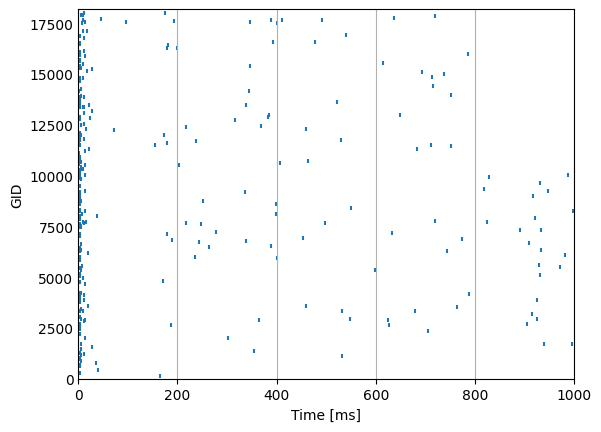

In [140]:
bluepy_sim.plot.raster(sample=18000, t_start=0.0, t_end=1000);        # bluepy

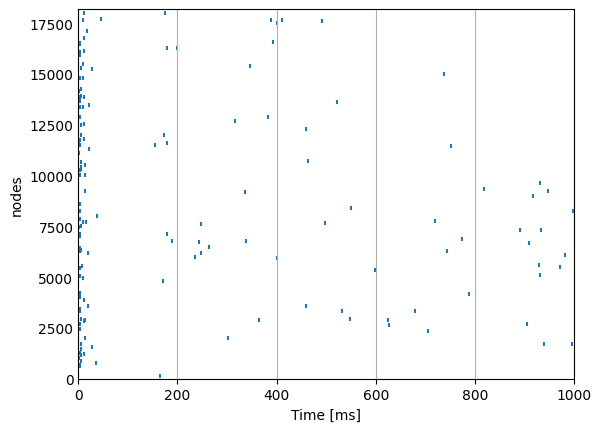

In [141]:
sample = snap_spikes.simulation.circuit.nodes.ids().sample(18000)      # snap, id selection
filtered = snap_spikes.filter(group=sample, t_start=0.0, t_stop=1000)  # snap, data collection
filtered.raster();                                                     # snap, plotting

The great advantage here is the possibility to call all the other plotting functions without reloading the data from disk:


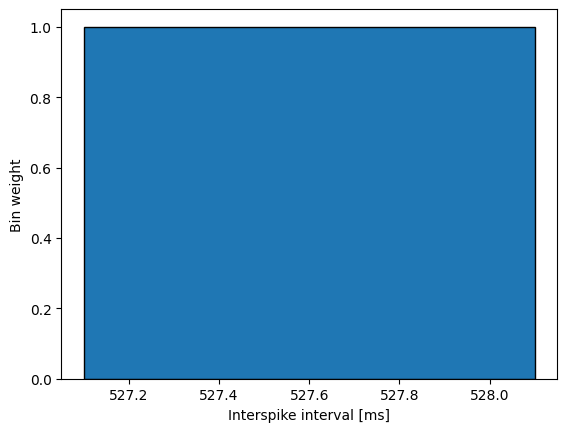

In [142]:
filtered.isi();                                                        # snap

This one above is not super nice due to the simulation itself. It comes from a CA1 Simulation and CA1 is quite silent.

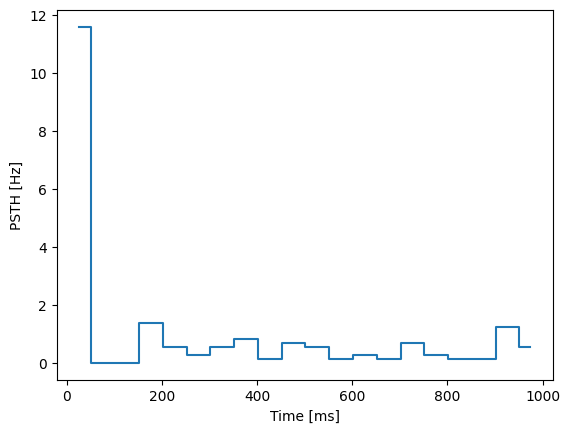

In [143]:
filtered.firing_rate_histogram();                                      # snap

In the 3 cells above, only the plotting part is run and not the data retrieval. While in bluepy, the data are re-collected for all plots which leads to much worse performances.


Plus, in snap, you can recheck the properties of your input data afterwards:

In [144]:
filtered.t_start, filtered.t_stop, filtered.group;                     # snap
filtered.report;

We also improved some of the plotting functions and removed the complex ones. The raster can now be used to project the spikes on any variables :


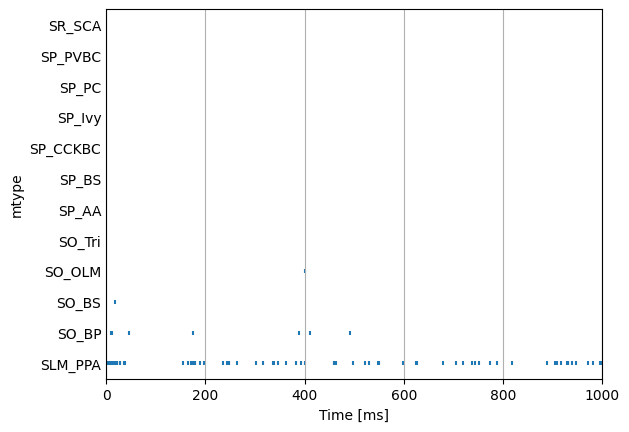

In [145]:
filtered.raster(y_axis="mtype");

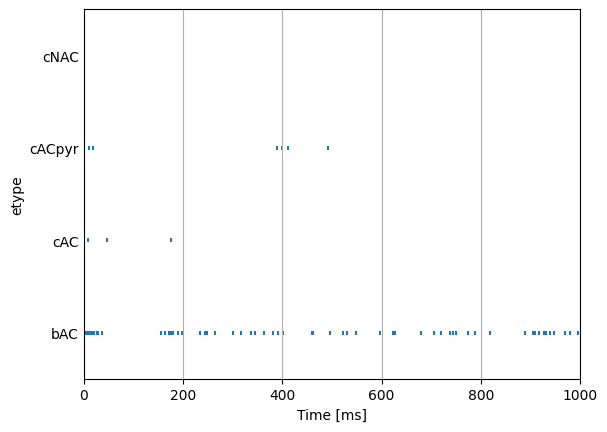

In [146]:
filtered.raster(y_axis="etype");                                       # snap

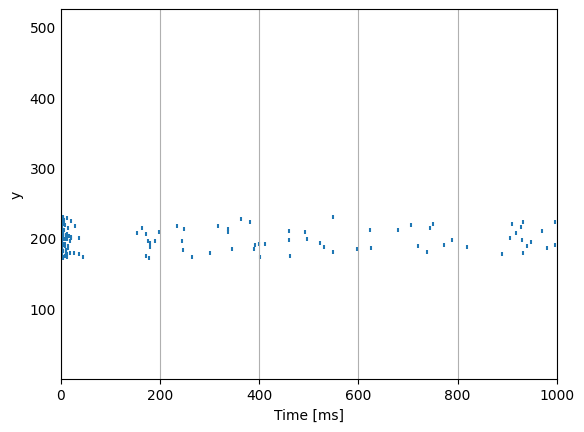

In [147]:
filtered.raster(y_axis="y");                                           # snap 

#### Plots on reports

The same has been done for the plots on reports :

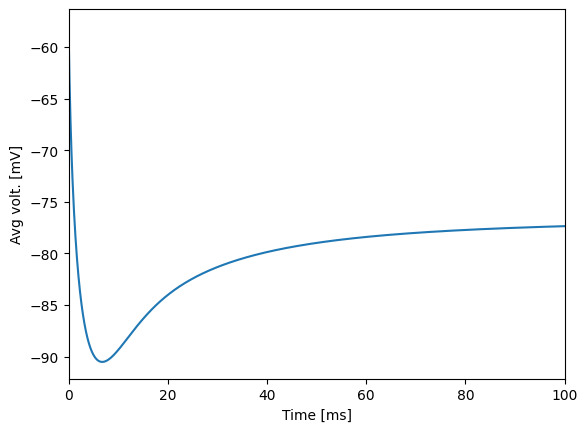

In [148]:
filtered = snap_report.filter(group={"mtype": "SLM_PPA"}, t_start=0, t_stop=100)    # snap
filtered.trace();                                                                   # snap

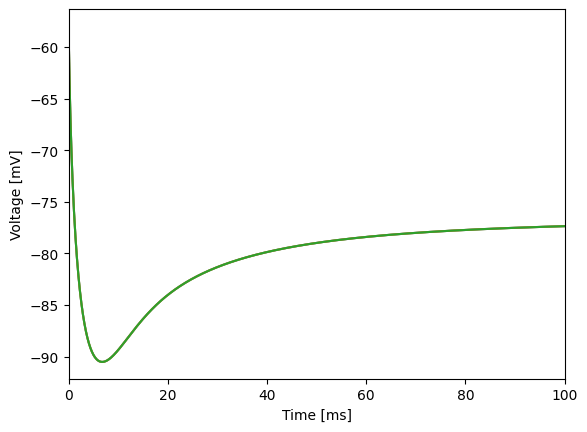

In [149]:
filtered.trace(plot_type="all");                    #  snap, this one will be instantaneously plotted  